In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Проект "ВИКИ-шоп"

## Описание проекта
Для интернет-магазина «Викишоп» необходим инструмент, позволяющий определять "токсичные" комментарии среди отредактированных пользователями комментариев товаров.

### Цель
Построить модель классификации комментариев пользователей на "токсичные" и "позитивные".

### Задачи
1. Обработать предоставленную выборку
2. Подготоить незаисимые признаки для моделей классификации 
3. Построить модели классификации тектовой информации
4. Добиться значения метрики качества F1 не меньше 0.75.

### Описание данных
1. Данные лежат в файле `toxic_comments.csv`. 
2. Целевая переменная находится в столбце `toxic`.

###  Этапы проекта:
- Исследование данных:
    - загрузка данных
    - оценка данных (типы переменных, типы категорий (номинативная, количественная))
- Предъобработка данных:
    - проверка и переименование названий столбцов
    - обработка текстов
    - проверка насбалансированность целевой переменной 
- Исследование данных на предмет применимости для машинного обучения
    - изучение признаков и целевой переменной
    - проверка на сбалансированность целевой переменной
    - расчет дополнительных признаков (через BERT модель, TF-IDF - матриц)
- Машинное обучение с учителем
    - подготовка функции, реализующей выбор лучших гиперпараметров с использованием метода GridSearch и кроссвалидации, минимизирующей риски переобучения моделей
    - разделение обработанного ДФ на обучающую и тестовую повыборки 
    - подбор гиперпараметров с помощью метода кроссвалидации
    - проверка моделей на тестовой выборке
    - выбор лучщей модели с учетом критериев заказчика



# Подготовительный этап

### Загрузка библиотек

In [4]:
! pip install transformers
#! pip install cuda-python
! pip install spacy
! pip install lightgbm
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#base tools
import re
import time
import copy
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML prepare tools
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer, TfidfTransformer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#NLP
#import cuda
import torch
import nltk
from nltk.probability import FreqDist

#visual
from IPython.display import Markdown
from IPython.display import display
from ipywidgets import widgets, Dropdown
from tqdm import notebook
from tqdm.auto import tqdm
import PIL
from PIL import Image

import lightgbm
from lightgbm import LGBMClassifier
import spacy 
import transformers 
#from transformers import *
from wordcloud import WordCloud

### Определение прогресс-комментария

In [6]:
tqdm.pandas(desc="Cleaning and lemmatizing progress ...")

### Загрузка "стоп-слов"

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Загрузка данных для модуля лемматизации

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

## Загрузка данных

In [10]:
try:
  data = pd.read_csv('/content/sample_data/toxic_comments.csv', index_col=0)
except:
    try:
        data = pd.read_csv('/content/toxic_comments.csv', index_col=0)
    except:
        data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
        


### Загрузка предъобученной модели BERT


In [11]:
#Библиотеки для BERT
#model_name = "unitary/toxic-bert" # модель BERT обученная на токсичных текстах, f1~0.95
#model = AutoModel.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

### Определение функций

In [12]:
def clean_text(text, patterns):
    text = re.sub(patterns, ' ', text)
    text = "".join(text)
    text = text.strip()
    return text

In [13]:
def delete_repeat_letters(text):
    pattern = re.compile(r'(\w)(\1{2,})')
    repl = r'\1'
    text = re.sub(pattern, repl, text)
    text = "".join(text)
    text = text.strip()
    return text

In [14]:
def lemma_text(string, lemm_obj):
    doc = lemm_obj(string) 
    lemma_list = " ".join([token.lemma_ for token in doc])
    return lemma_list

In [15]:
def delete_stop_words(text, stop_words):
    tokens = []
    for token in text.split():
        if token not in stop_words and len(token) > 2:
            tokens.append(token)
    text = " ".join(tokens)
    return text

In [16]:
def find_uninfo(df, numb):
    un_infos = []
    for column in notebook.tqdm(df.columns):
        un_info = df[column].sum()
        if un_info < numb:
            un_infos.append(column)
    return un_infos

In [17]:
def search_best_params(X, y_true, model_obj, grid_params, STOP_EN):
    pipe = Pipeline([                    
                    ('tfidf', TfidfVectorizer(stop_words = STOP_EN)),
                    ('model', model_obj)
                    ])
    
    grid_obj = GridSearchCV(estimator=pipe, param_grid=grid_params, n_jobs=-1, cv=5, scoring = 'f1', verbose=1) 
    
    print(f'START fiting in {time.strftime("%H:%M:%S", time.localtime())}')
    start = time.time()
    grid_obj.fit(X, y_true)
    end = time.time()
    grid_time = (end - start)
   
    print(f'Grid searching finished. \
    F1: {grid_obj.best_score_},\
    Grid time: {grid_time} s,\
    Fit time: {np.mean(grid_obj.cv_results_.get("mean_fit_time"))} s,\
    Predict time: {np.mean(grid_obj.cv_results_.get("mean_score_time"))} s')

    times = (grid_time, np.mean(grid_obj.cv_results_.get('mean_fit_time')), \
             np.mean(grid_obj.cv_results_.get('mean_score_time')))

    #Выводим лучшие гиперпараметры
    try:
        print(f'best params: {grid_obj.best_params_}')
    except:
        print(f'проблемы с поиском лучшей модели')
     
    return (grid_obj, times)   

In [18]:
def write_results(dict_with_new_result, all_results = None):
    if not all_results:
        #Словарь, который будет аккумулироваь результаты
        all_results = {'step': [], 'model_name': [], 'F1': [], 'fit_time': [], 'predict_time': [],
                   'feature_importances': [], 'grid_time': []}

    all_results['step'].append(dict_with_new_result.get('step'))
    all_results['model_name'].append(dict_with_new_result.get('model_name'))
    all_results['F1'].append(dict_with_new_result.get('F1'))
    all_results['fit_time'].append(dict_with_new_result.get('fit_time'))
    all_results['predict_time'].append(dict_with_new_result.get('predict_time'))
    all_results['grid_time'].append(dict_with_new_result.get('grid_time'))
    all_results['feature_importances'].append(dict_with_new_result.get('feature_importances'))
    return all_results

In [19]:
def draw_features(model, X):    
    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
    fig.suptitle('Распределение значимости признаков', fontsize=14, fontweight='bold');
       
    sns.barplot(y = model.feature_importances_, x = X);

In [20]:
def try_on_test(model, model_name, train_f, train_t, test_f, test_t, results):
    #Обучение на полной выборке
    model.fit(train_f, train_t)
    
    #Предсказание
    predict = model.predict(test_f)

    #Расчет метрик
    F1 = f1_score(test_t, predict)
    print(f' test F1: {F1}') 

    #Заполняем Словарь с результатами
    rez = {'step': 'test', 'model_name': model_name, 'F1': F1}

    results = write_results(rez, results)
    return results

In [21]:
 def prepare_calc_embendings(df, text_col, tokenizer):
    #Создаем списки токенов
    df['tokenized'] = df[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512)))

    #Определяем максимальную длину списков
    df['lengs'] = df.tokenized.apply(lambda x: len(x))
    max_len = df.lengs.max()

    #Добиваем все списки до максимальной длины
    padded = np.array([i + [0]*(max_len - len(i)) for i in df.tokenized.values])

    #Формируем маску
    attention_mask = np.where(padded != 0, 1, 0)

    #Удаляем лишнее
    df = df.drop(['tokenized', 'lengs'], axis = 1)
    del df

    return (padded, attention_mask)

In [22]:
def calc_embenings(sample_size, input_padded, input_mask):
    #Расчитываем эмбендинги BERT-моделью
    last_hidden_states = []
    for idx in notebook.tqdm(range(input_padded.shape[0] // sample_size)):
        try:
            input_sample = \
            torch.tensor(input_padded[idx*(sample_size + 1) : idx*(sample_size + 1) + sample_size]).cuda()
            mask_sample =  \
            torch.tensor(input_mask[idx*(sample_size + 1) : idx*(sample_size + 1) + sample_size]).cuda()
    
            with torch.no_grad():
                model.cuda()
                last_hidden_state = model(input_sample, attention_mask=mask_sample)
    
            last_hidden_states.append(last_hidden_state[0][:,0,:].cpu().numpy())
    
            del last_hidden_state
            del input_sample
            del mask_sample
        except:
            print("error in step:", idx)
            break
    return last_hidden_states

In [23]:
  def read_embendings():
    url = 'https://docs.google.com/spreadsheets/d/1njpC5eK9dxuZlbrufoaGmqVos8XtV5yn/edit?usp=share_link&ouid=116410101676708186808&rtpof=true&sd=true'
    file_id=url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?id=' + file_id
    df = pd.read_csv(dwn_url)
    return df

In [24]:
#Выпадающий список для выбора тактики расчета кросс-валидации
cbox_cross_lr = Dropdown(
    options=[('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)],
    value=0, # Выбор по умолчанию
    description='Выбор:' )

cbox_cross_rf = Dropdown(
    options=[('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)],
    value=0, # Выбор по умолчанию
    description='Выбор:' )

cbox_cross_gbm = Dropdown(
    options=[('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)],
    value=0, # Выбор по умолчанию
    description='Выбор:' )

In [25]:
#Выпадающий список для выбора тактики взаимодействия с BERT
cbox_bert = Dropdown(
    options=[('BERT не нужен', 0), ('Считать эмбендинги из файла', 1), \
             ('Расчитывать эмбендинги', 2)],
    value=0, # Выбор по умолчанию
    description='Выбор:' )

In [26]:
#Выпадающий список для выбора тактики расчета кросс-валидации
cbox_cross_bert = Dropdown(
    options=[('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)],
    value=0, # Выбор по умолчанию
    description='Выбор:' )

### Задание констант

In [27]:
RAND_ST = 42
STOP_EN = nltk.corpus.stopwords.words('english')
STOP_PT = "[^a-zA-Z]+"

#По-умолчанию модели не пересчитываются и bert не используется
comp_state = 0
bert_state = 0

#random_state по-умолчанию
random.seed(42)

## Изучение данных

### Характеристики датасета

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [29]:
data.sample(10)

,text,toxic
118908,"""UNLESS YOU""""RE JIMBO WALES INFORMING ME OF MY...",0
132565,Barack Obama is not a socialist. Anybody with ...,0
148226,Your wife isn't half bad \nCan I fuck her?,1
149418,"I'm going on a long vacation soon, so hopefull...",0
57525,"Idiocy\n\nI made a number of changes, clearly ...",1
51643,"If you're that sensitive, why don't you kill y...",1
33004,Deletion Review \n\nPlease revisit the deletio...,0
76763,"""\n\nTo further clarify, even though """"club te...",0
31885,""" \nAlright, first off:\nPlease remember to si...",0
14496,Expanding Bay Area definition to match Census ...,0


В ДФ три столбца:
- 0 - Unnamed: 0, содержащий данные, напоминающие индексы
- text, содержащий текст комментариев
- toxic, содержащий целевую переменную



## Характеристики целевой переменной

### Поиск аномальных значений

In [30]:
data.toxic.unique()

array([0, 1])

### Распределение целевой переменной

In [31]:
ratio = data.groupby(by  = 'toxic', as_index = False).agg(ratio = ('toxic', 'count'))
ratio['prs'] = round(100*ratio.ratio/ratio.ratio.sum(), 2)
ratio

,toxic,ratio,prs
0,0,143106,89.84
1,1,16186,10.16


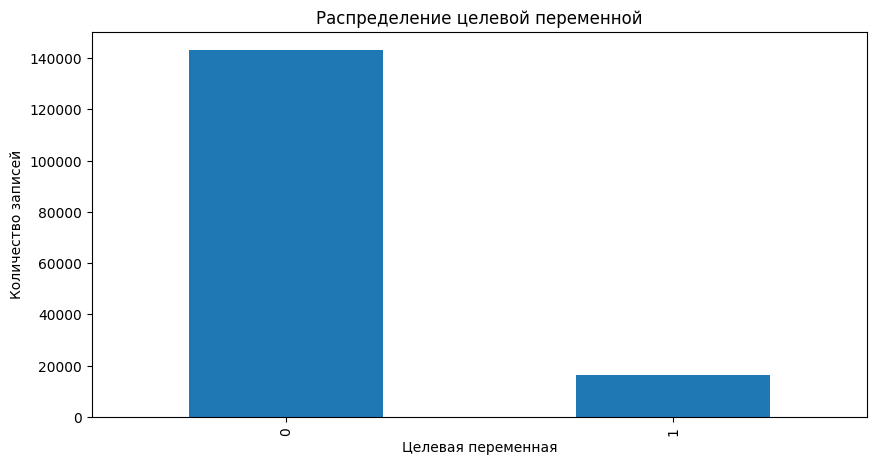

In [32]:
ratio.ratio.plot(kind = 'bar', xlabel = 'Целевая переменная', ylabel = 'Количество записей', \
                 title = 'Распределение целевой переменной', figsize = (10, 5));

Целевая переменная разбалансированна. Значений "1" много больше "0", 89.84% против 10.16%. Необходимо это учесть при разбиении данных на выборки и обучении моделей

## Характеристики текстовых данных

In [33]:
data.text

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159446    ":::::And for the second time of asking, when ...
159447    You should be ashamed of yourself \n\nThat is ...
159448    Spitzer \n\nUmm, theres no actual article for ...
159449    And it looks like it was actually you who put ...
159450    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

В ДФ размещены необработанные "оригинальные" текстовые сообщения. Для них необходимо провести:
- отчистку данных от лишних символов
- удаление многократно повторяющихся символов (например aaaaaany -> any) 
- токенизацию
- лемматизацию

## Предобработка текстов

### Лемматизация и отчистка

In [34]:
#Отчистка текста
data['cleaned'] = data.text.progress_apply(clean_text, **{'patterns': STOP_PT})

#Удаление повторяющихся символов
data['cleaned'] = data.cleaned.progress_apply(delete_repeat_letters)

#Лемматизация текста
lemm_obj = nlp
data['cleaned'] = data.cleaned.progress_apply(lemma_text, **{'lemm_obj': lemm_obj})

#Удаление стоп-слов
data['cleaned'] = data.cleaned.progress_apply(delete_stop_words, **{'stop_words': STOP_EN})

#Приведение к строчному виду
data['cleaned'] = data.cleaned.str.lower()

#Удаляем столбец с текстом
data = data.drop('text', axis = 1)

Cleaning and lemmatizing progress ...:   0%|          | 0/159292 [00:00<?, ?it/s]

Cleaning and lemmatizing progress ...:   0%|          | 0/159292 [00:00<?, ?it/s]

Cleaning and lemmatizing progress ...:   0%|          | 0/159292 [00:00<?, ?it/s]

Cleaning and lemmatizing progress ...:   0%|          | 0/159292 [00:00<?, ?it/s]

### Частотный анализ текстов

[('article', 72982),
 ('page', 56931),
 ('wikipedia', 48523),
 ('talk', 40392),
 ('edit', 37177)]

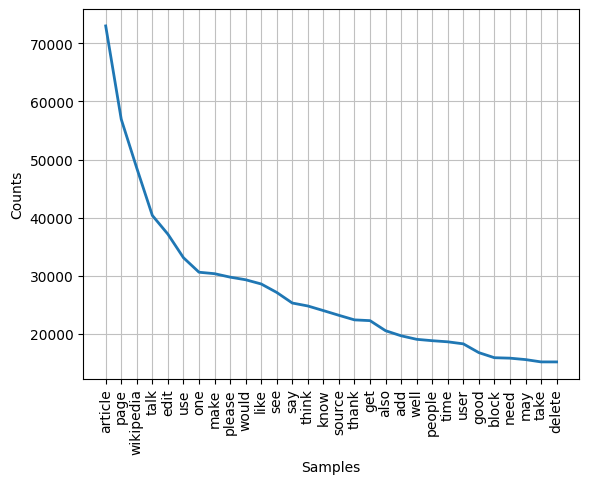

<Axes: xlabel='Samples', ylabel='Counts'>

In [35]:
#Сформируем полный список токенов
all_strings = " ".join(data.cleaned)
all_tokens = all_strings.split()

#Преобразуем список токенов к типу Text
text = nltk.Text(all_tokens)

#Расчитываем частотность текста
fdist = FreqDist(text)

#Наиболее часто встречающиеся слова
display(fdist.most_common(5))

#График частот для наиболее часто встречающихся слов
fdist.plot(30,cumulative=False)

### Облако слов

In [36]:
try:
    or_im = Image.open('cloud.jpg')
    image = or_im.resize([2000,2000], Image.ANTIALIAS)
    image = np.array(image)
    wordcloud = WordCloud(width = 1000, height = 1000, background_color = 'white', colormap = 'Set2', collocations = False, mask = image).generate(all_strings) 
except:
    wordcloud = WordCloud(width = 1000, height = 1000, background_color = 'white', colormap = 'Set2', collocations = False).generate(all_strings) 
    

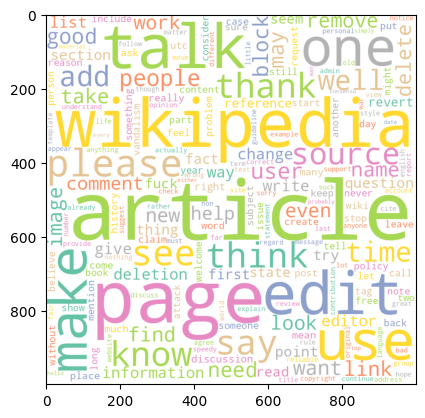

In [37]:
plt.imshow(wordcloud )

## Подготовка данных для обучения

### Расчет или считывание признаков, полученных через BERT

Так как расчет эмбендингов моделью BERT ресурсо затратный и длительный процесс в тетрадке реализована возможность учета расчитанных ранее результатов.
*   Если необходимо выполнить вычисления -> выбираем "Расчитывать эмбендинги"
*   Если необходимо посмотреть ранее рассчитанные резутльтаты -> выбираем "Считать эмбендинги из файла"
*   Если нет необходимости в BERT -> выбираем "BERT не нужен" (значение по-умолчанию)

In [38]:
display("Тактика расчета эмбендингов")
display(cbox_bert)

'Тактика расчета эмбендингов'

Dropdown(description='Выбор:', options=(('BERT не нужен', 0), ('Считать эмбендинги из файла', 1), ('Расчитыват…

In [39]:
bert_state = cbox_cross_bert.value
#Считыванием заранее расчитанные эмбендинги
if bert_state == 1:
    try:
        X_data = pd.read_csv("calc_emb.csv")
    except:
        #Читаем с google-диска
        X_data = read_embendings()
    bert_data = X_data.drop('Unnamed: 0', axis = 1, errors = 'ignore')

#Расчитываем эмбендинги
elif bert_state == 2:
    #Расчитываем входной вектор и маску
    bert_data = copy.deepcopy(data)
    padded, attention_mask = prepare_calc_embendings(bert_data, 'cleaned', tokenizer)
    del bert_data
    
    #Расчитываем эмбендинги BERT-моделью
    last_hidden_states = calc_embenings(10, padded, attention_mask)
    del padded
    del attention_mask
    
    #Формируем из эмбендингов ДФ
    bert_data = pd.DataFrame(np.concatenate(last_hidden_states))
    bert_data['toxic'] = data.toxic[:bert_data.shape[0]]
    
    #Записываем ДФ с эмбендингами в csv файл
    bert_data.to_csv("calc_emb.csv")

#Ничего не делаем
else:
    print("Работаем без BERT")

Работаем без BERT


### Разделение на обучающую и тестовую выборки

Для сохранения постоянного(одинакового) дисбаланса классов во всех выборках применим параметр stratify = data.toxic

In [40]:
train_f, test_f, train_t, test_t = \
train_test_split(data.drop('toxic', axis = 1), data.toxic, \
                 test_size = 0.1, random_state = RAND_ST, shuffle = True, stratify = data.toxic)

In [41]:
if bert_state != 0:
    train_bert, test_bert, train_tbert, test_tbert = \
      train_test_split(bert_data.drop(['toxic', 'Unnamed: 0'], axis = 1, errors = 'ignore'), bert_data.toxic,  test_size = 0.1, random_state = RAND_ST, shuffle = True)
else:
    "Работаем без BERT"

## Дообработка текста

### Расчет  TF-IDF

In [42]:
#Создаем объект счетчика TF-IDF
counter = TfidfVectorizer(stop_words = STOP_EN, min_df = 39) 

#Обучаем счетчик на обучающей выборке
counter.fit(train_f['cleaned'])

#Расчет TF-IDF на обучающей выборке
tfidf_train = counter.transform(train_f['cleaned'])

#Расчет TF-IDF на тестовой выборке
tfidf_test = counter.transform(test_f['cleaned'])

Размерность матрицы признаков (TF-IDF) получилась невероятно большая. Чтобы вычислительных мощностей хватило обработать признаки и обучить модели классификации, снизим размер матрицы признаков, удалив редко встречающиеся словосочетания.

## Подбор моделей без BERT

Так как подбор гиперпараметров моделей через кросс-валидацию занимает в среднем 1.5 часа на каждую модель в тетрадке реализована возможность учета расчитанных ранее результатов.
*   Если необходимо выполнить вычисления -> выбираем "Cчитать заново"
*   Если необходимо посмотреть ранее рассчитанные резутльтаты -> выбираем "Учесть ранее рассчитанные результаты"







In [43]:
display("Тактика расчета кросс-валидации LogisticRegression")
display(cbox_cross_lr)

'Тактика расчета кросс-валидации LogisticRegression'

Dropdown(description='Выбор:', options=(('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)), v…

### LogisticRegression

In [44]:
comp_state = cbox_cross_lr.value
if comp_state == 1:

    lr_model = LogisticRegression(random_state = RAND_ST)
    lr_params = [{ 'tfidf__min_df': [38, 39],
                   'model__C': [8, 9, 10],
                   'model__penalty': ['l2'],
                   'model__max_iter': [1000]
                   }] 

    (lr_grid, times) = search_best_params(train_f.cleaned, train_t, lr_model, lr_params, STOP_EN)

    #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'LogisticRegression', 
       'F1': lr_grid.best_score_, 'fit_time': times[1], 'predict_time': times[2], 'grid_time': times[0]}
else:
    #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'LogisticRegression', 
       'F1': 0.7776, 'fit_time': 38.042, 'predict_time': 2.7065, 
       'grid_time': 499.7288}

    display(Markdown(f'\n **Ячейка не выполняется**. \
  Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:\
  Mean fit time: {rez["fit_time"]} s \n\
  Mean predict time: {rez["predict_time"]} s \n\
  mean F1: {rez["F1"]}')) 

results = write_results(rez)


 **Ячейка не выполняется**.   Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:  Mean fit time: 38.042 s 
  Mean predict time: 2.7065 s 
  mean F1: 0.7776

### RandomForestClassifier

In [45]:
display("Тактика расчета кросс-валидации RandomForestClassifier")
display(cbox_cross_rf)

'Тактика расчета кросс-валидации RandomForestClassifier'

Dropdown(description='Выбор:', options=(('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)), v…

In [46]:
comp_state = cbox_cross_lr.value
if comp_state == 1:
    rf_model = RandomForestClassifier(random_state = RAND_ST)
    rf_params = [{
                   'tfidf__min_df': [30, 35, 38, 39],
                   'model__n_estimators': range(100, 150, 50), 
                   'model__min_samples_split': range(2, 4, 2), \
                   'model__min_samples_leaf': range(5, 10, 2)
                    }] 

    (rf_grid, times) = search_best_params(train_f.cleaned, train_t, rf_model, rf_params, STOP_EN)

    #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'RandomForestClassifier', 
       'F1': rf_grid.best_score_, 'fit_time': times[1], 'predict_time': times[2],
       'grid_time': times[0]}

    results = write_results(rez, results)

else:
    rez = {'step': 'train', 'model_name': 'RandomForestClassifier', 
       'F1': 0.7322, 'fit_time': 275.089, 'predict_time': .1516, 'grid_time': 2347.732}
  
    display(Markdown(f'\n **Ячейка не выполняется**. \
  Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:\
  Mean fit time: {rez["fit_time"]} s \n\
  Mean predict time: {rez["predict_time"]} s \n\
  mean F1: {rez["F1"]}')) 

results = write_results(rez, results)
#{'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'tfidf__min_df': 39}


 **Ячейка не выполняется**.   Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:  Mean fit time: 275.089 s 
  Mean predict time: 0.1516 s 
  mean F1: 0.7322

### LightGBM

In [47]:
display("Тактика расчета кросс-валидации LightGBM")
display(cbox_cross_gbm)

'Тактика расчета кросс-валидации LightGBM'

Dropdown(description='Выбор:', options=(('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)), v…

In [48]:
comp_state = cbox_cross_gbm.value
if comp_state == 1:

    gbm_model = LGBMClassifier(objective = 'binary', is_unbalance = True, random_state = RAND_ST)
    gbm_params = {'model__learning_rate': [ 0.2],
                  'model__num_leaves': [60, 70],
                  'model__n_estimators': [400, 500],
                  'model__boosting_type': ['gbdt']
                  }

    (gbm_grid, times) = search_best_params(train_f.cleaned, train_t, gbm_model, gbm_params, STOP_EN)

  #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'LightGBM', 
       'F1': gbm_grid.best_score_, 'fit_time': times[1], 'predict_time': times[2], 'grid_time': times[0]}

    results = write_results(rez, results)

else:
    rez = {'step': 'train', 'model_name': 'LightGBM', 
       'F1':0.7740, 'fit_time': 684.615, 'predict_time': 16.413, 'grid_time': 2538.381}
       
    display(Markdown(f'\n **Ячейка не выполняется**. \
  Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:\
  Mean fit time: {rez["fit_time"]} s \n\
  Mean predict time: {rez["predict_time"]} s \n\
  mean F1: {rez["F1"]}'))

results = write_results(rez, results)
#best params: {'model__learning_rate': 0.3, 'model__max_depth': 20}


 **Ячейка не выполняется**.   Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:  Mean fit time: 684.615 s 
  Mean predict time: 16.413 s 
  mean F1: 0.774

## Расчет линейной регрессии с BERT

In [49]:
display("Тактика расчета кросс-валидации")
display(cbox_cross_bert)

'Тактика расчета кросс-валидации'

Dropdown(description='Выбор:', options=(('Учесть ранее рассчитанные результаты', 0), ('Cчитать заново', 1)), v…

In [50]:
### Надо менять из-за добавления pipline
comp_state = cbox_cross_bert.value
if comp_state == 1 and bert_state != 0:
    bert_lr_model = LogisticRegression()
    bert_lr_params = {'random_state' : [RAND_ST], 'max_iter': [1000]}

    (bert_lr_grid, times, F1) = search_best_params(train_bert, train_tbert, bert_lr_model, bert_lr_params, RAND_ST, STOP_EN)

  #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'LogisticRegression (bert)', 
       'F1': F1, 'fit_time': times[1], 'predict_time': times[2], 'grid_time': times[0]}
else:
    #Заполняем Словарь с результатами
    rez = {'step': 'train', 'model_name': 'LogisticRegression (bert)', 
       'F1': 0.498, 'fit_time': 16.75, 'predict_time': 0.017, 
       'grid_time': 590.344}

    display(Markdown(f'\n **Ячейка не выполняется**. \
  Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:\
  Mean fit time: {rez["fit_time"]} s \n\
  Mean predict time: {rez["predict_time"]} s \n\
  mean F1: {rez["F1"]}')) 

results = write_results(rez, results)


 **Ячейка не выполняется**.   Ранее полученные на этапе кросс-валидации результы зафиксированы в разделе "Сравнение моделей" и представлены ниже:  Mean fit time: 16.75 s 
  Mean predict time: 0.017 s 
  mean F1: 0.498

## Сравнение моделей

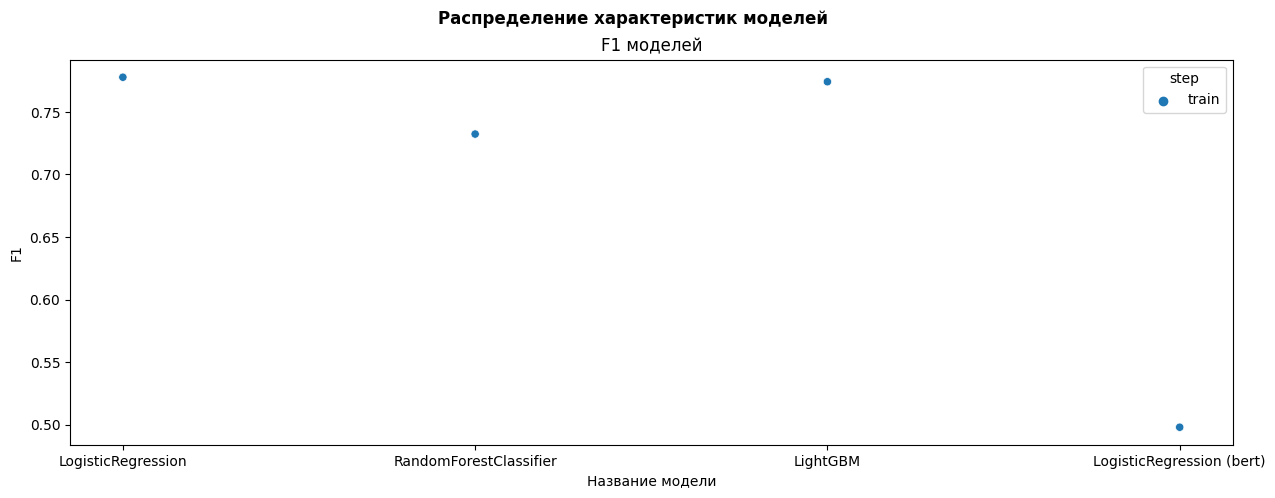

In [51]:
df_results = pd.DataFrame(results)
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение характеристик моделей', fontsize=12, fontweight='bold');
sns.scatterplot(y =  df_results.F1, x = df_results.model_name, ax = axes, hue = df_results.step);

axes.set_xlabel("Название модели");
axes.set_ylabel("F1");
axes.set(title = "F1 моделей");

In [52]:
display(df_results.sort_values(by = 'F1', ascending = False))

,step,model_name,F1,fit_time,predict_time,feature_importances,grid_time
0,train,LogisticRegression,0.7776,38.042,2.7065,None,499.7288
2,train,LightGBM,0.7740,684.615,16.4130,None,2538.3810
1,train,RandomForestClassifier,0.7322,275.089,0.1516,None,2347.7320
3,train,LogisticRegression (bert),0.4980,16.750,0.0170,None,590.3440


### Вывод по результатам сравнения

In [53]:
best_F1 = df_results.query('step == "train"').F1.max()
best_model =  df_results.query('step == "train" and F1 == @best_F1')
display(Markdown(f'\n По результатам сравнение метрик качества установлено, \
что лучшей моделью является **{best_model.model_name.values[0]}**\n'))    
display(Markdown(f'\n c F1 на тренировочной выборке **{best_model.F1.values[0]}.**\n'))


 По результатам сравнение метрик качества установлено, что лучшей моделью является **LogisticRegression**



 c F1 на тренировочной выборке **0.7776.**


## Тестирование

In [54]:
%%time
best_model = LGBMClassifier(objective = 'binary', is_unbalance = True, learning_rate = 0.2, num_leaves = 70,\
                            n_estimators = 500, boosting_type = 'gbdt')

results = try_on_test(best_model, 'LGBMClassifier', \
                      tfidf_train, train_t, tfidf_test, test_t, results)

 test F1: 0.7784283513097072
CPU times: user 6min 41s, sys: 1.52 s, total: 6min 42s
Wall time: 6min 43s


### Визуализация результатов

In [55]:
#Предсказания в вероятностях
y_score = best_model.predict_proba(tfidf_test)[:,1]

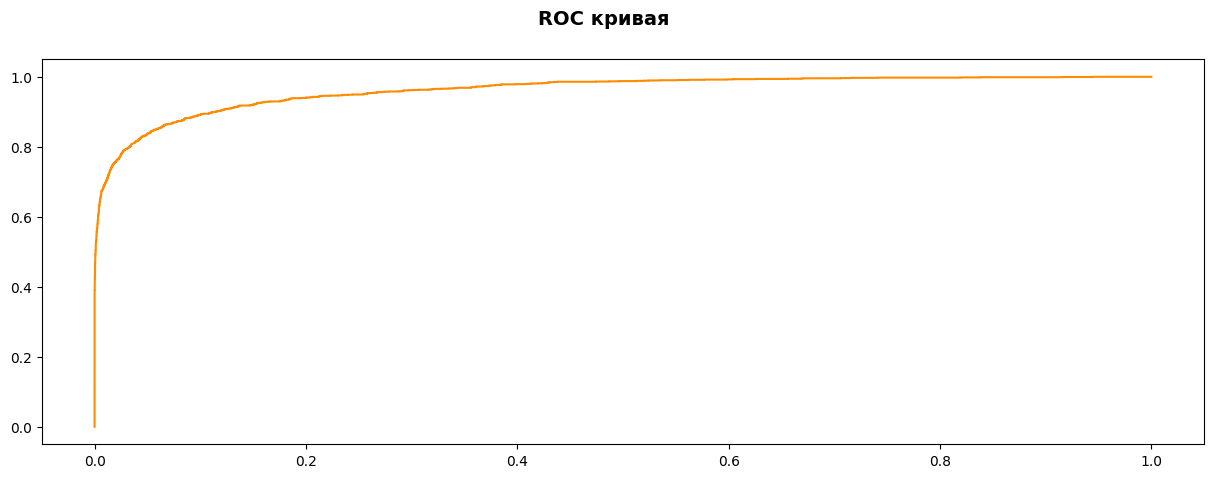

In [56]:
#Roc-кривая
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 5))
fpr, tpr, treshold = roc_curve(test_t, y_score)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)

fig.suptitle('ROC кривая', fontsize=14, fontweight='bold');

## Выводы по результатам исследования
Целью исследования было подготовить модель кластеризации комментариев (текстов) на токсичные и нетоксичные. Модель должна была быть разработана на основании заранее размеченного корпуса текстов (предостален в csv файле). Показателем качества модели требовалось принять F1-меру, которая должна быть не меньше 0.75 на тестовых данных. При выборе модели важна только точность предсказания.
В процесе исследования:
1.   Загружен корпус размеченных текстов 
2.   Исследованы загруженные данные
3.   Выполнен EDA, включая:
*   проверку корректности назначенных типов данных (ничего не меняли)
*   удаление неинформативных столбцов ('Unnamed:0')
*  изучение текстовой информации (тексты содержат излишне повторяющиеся символы, "мусорные" символы, строчные и прописные символы, пробелы)
*  проверка сбалансированности целевой переменной (переменная не сбалансирована)
4. Исключен дисбаланас целевой переменной за счет удаления части "нетоксичных" строк.
5.   Проведена подготовка данных к машинному обучению, тексты отчищены:
*  от повторяющих более 3-х раз подряд символов
*  от мусорных символов (;$& и т.д.)
*  от лишних пробелов
*  от стоп-слов 
6.   Тексты лемматизированы
7. Для текстов посчитаны матрицы TF-IDF (статистическая мера, используемая для оценки важности слова в контексте документа)
8. Размерность матрицы снижена за счет удаления редких слов (менее 3 вхождений) 
9. Для текстов локально посчитаны и загружены через google-диск эмбендинги предъобученной модели BERT
10. Подготовлены функции, автоматизирующие:
*  предъобратотку текстов
*  расчет, считывание и запись эмбендингов
*  перебор гиперпараметров на основе метода GridSearch и кросс-валидации
*  фиксацию результатоввычислений в отдельных ДФ
11. Проведено машинное обучение, использованы модели:
*  LogisticRegression
*  RandomForestClassifier
*  HistGradientBoostingClassifie
*  KNeighborsClassifier
12. Подобраны гиперпараметры для указанных моделей, оценена метрика качества, полученная на обучающей выборке, модель с оптимальными гиперпараметрами проверены на тестовой выборке.
13. По результатам сравнение результатов, установлено, что лучшей моделью является LightGBM c F1 на тестовой выборке 0.78
14. Результаты визуализированы ROC_AUC кривой